# Instagram data and feature extraction
This notebook contains a series of scrips that combine and extract
features from the instagram dataset. This dataset is retrieved from
the canvas board of Fundamentals of Datascience, given at the UvA.

**Author**: Tycho Atsma <tycho.atsma@student.uva.nl>\
**File**: instagram_data_extraction.ipynb\
**Date**: Friday, 4 October 2019

In [104]:
# dependencies
from __future__ import division
import pandas as pd
import numpy as np
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import os
import math
from scipy.ndimage.filters import gaussian_filter1d
from collections import Counter
from Sanitizer import Sanitizer
import statistics
%matplotlib inline

## Datasets
The data given is split up in multiple files. Each file contains data that is not directly related to the other files.
The challenge is to combine these into one, large dataset. This can be done by loading all datasets into seperate
dataframes and merging these together. The dataset containing survey data is the target dataset. Therefore, this dataset should not be part of the main dataset. 

In [2]:
# we need a path to the directory that contains all datasets
base_path = '../assignments/Assignment 2/visual_well_being_pickle_format/'

# we need a seperate dataset for the survey data
survey_df = pd.read_pickle(base_path + 'survey.pickle')

# we need a list of file names of the datasets
file_names = ['anp', 'face', 'image_data', 'image_metrics']

# we need a list of all dataframes
dataframes = [pd.read_pickle(os.path.join(base_path, fn + '.pickle')) for fn in file_names]

In [3]:
# we need to combine the list of dataframes into one, large dataset
large_df = pd.concat(dataframes, join="outer", sort=False)
print(large_df.shape)
large_df.head()

(498242, 42)


,image_id,anp_label,anp_sentiment,emotion_score,emotion_label,face_id,face_gender,face_gender_confidence,face_age_range_high,face_age_range_low,...,user_website,user_profile_pic,user_bio,user_followed_by,user_follows,user_posted_photos,comment_count,comment_count_time_created,like_count,like_count_time_created
0,951727030670259635_143763900,hot_boys,0.017,0.1760,amazement,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,951727030670259635_143763900,young_couple,0.019,0.2113,joy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,951727030670259635_143763900,dirty_laundry,-0.263,0.0929,joy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,951727030670259635_143763900,global_mall,-0.031,0.1304,interest,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,951728575726873168_289794729,high_boots,0.025,0.1394,amazement,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset shows a number of rows that contain many NaN values. This is probably caused by the merge. Setting the index on the image, thus grouping the columns per image, may improve the data display. Besides the grouping, the dataset should not be polluted with duplicate rows.

In [4]:
# we need to drop all duplicates from the dataframe
large_df = large_df.set_index('image_id').drop_duplicates().reset_index()
print(large_df.shape)
large_df.head()

(163835, 42)


,image_id,anp_label,anp_sentiment,emotion_score,emotion_label,face_id,face_gender,face_gender_confidence,face_age_range_high,face_age_range_low,...,user_website,user_profile_pic,user_bio,user_followed_by,user_follows,user_posted_photos,comment_count,comment_count_time_created,like_count,like_count_time_created
0,951727030670259635_143763900,hot_boys,0.017,0.1760,amazement,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,951727030670259635_143763900,young_couple,0.019,0.2113,joy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,951727030670259635_143763900,dirty_laundry,-0.263,0.0929,joy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,951727030670259635_143763900,global_mall,-0.031,0.1304,interest,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,951728575726873168_289794729,high_boots,0.025,0.1394,amazement,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataframe contains rows indexed by an image id. Looking at the head of the dataframe, many columns contain `NaN` values. This is probably caused by the concatination of the multiple datasets. A dataset containing columns related to facial features may correspond to the same image as a dataset that contains columns with emotional scores. The preferred situation would be to combine the seperate rows from the concatinated dataframes into a single row, based on an image id.

In [5]:
# we need to check if our suspicion is correct. we can do this by retrieving all rows
# of a single image.
dups_row = large_df.loc[large_df.loc[:, 'image_id'] == '951727030670259635_143763900']
dups_row

,image_id,anp_label,anp_sentiment,emotion_score,emotion_label,face_id,face_gender,face_gender_confidence,face_age_range_high,face_age_range_low,...,user_website,user_profile_pic,user_bio,user_followed_by,user_follows,user_posted_photos,comment_count,comment_count_time_created,like_count,like_count_time_created
0,951727030670259635_143763900,hot_boys,0.017,0.1760,amazement,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,951727030670259635_143763900,young_couple,0.019,0.2113,joy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,951727030670259635_143763900,dirty_laundry,-0.263,0.0929,joy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,951727030670259635_143763900,global_mall,-0.031,0.1304,interest,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87445,951727030670259635_143763900,NaN,NaN,NaN,NaN,17.0,Female,100.000000,44.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87446,951727030670259635_143763900,NaN,NaN,NaN,NaN,17.0,Female,100.000000,44.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87447,951727030670259635_143763900,NaN,NaN,NaN,NaN,17.0,Female,100.000000,44.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87448,951727030670259635_143763900,NaN,NaN,NaN,NaN,76.0,Male,99.911095,15.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87449,951727030670259635_143763900,NaN,NaN,NaN,NaN,76.0,Male,99.911095,15.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87450,951727030670259635_143763900,NaN,NaN,NaN,NaN,76.0,Male,99.911095,15.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The suspicion is justified. The rows need to be merged now. This can be tested using the row output above.

In [6]:
# we need the columns of the row for zipping the values
# of a row to their column value
cols = dups_row.columns

# we need the list of values so we can iterate over them
vals = dups_row.values

# we need a list of rows with their values zipped by column name
rows = [list(zip(cols, row)) for row in vals]

def fillnan(row, otherrow):
    '''
    Function to fill nans in a row using values from another row based on index.
    '''
    
    # iterate over the rows values
    for (idx, (label, value)) in enumerate(row):
        
        # we need to check if it's a nan value
        if isinstance(value, float) and math.isnan(value):
            
            # we need the other row's value on this index
            othervalue = otherrow[idx][1]
            
            # check if there's a valid value in the other row
            if (isinstance(othervalue, float)) and math.isnan(othervalue):
                pass
            
            # set the value on the row
            row[idx] = otherrow[idx]
            
    # expose the new filled row
    return row

Merging rows turns out to be a difficult task. Another approach could be to process the datasets seperately before merging them into one large dataset. It may even prove that a single large dataset is not a suitable approach.

In [7]:
# we need to iterate over the dataframes
for df in dataframes:
    print("{}\n".format(df.columns))

Index(['image_id', 'anp_label', 'anp_sentiment', 'emotion_score',
       'emotion_label'],
      dtype='object')

Index(['image_id', 'face_id', 'face_gender', 'face_gender_confidence',
       'face_age_range_high', 'face_age_range_low', 'face_sunglasses',
       'face_beard', 'face_beard_confidence', 'face_mustache',
       'face_mustache_confidence', 'face_smile', 'face_smile_confidence',
       'eyeglasses', 'eyeglasses_confidence', 'face_emo', 'emo_confidence'],
      dtype='object')

Index(['image_id', 'image_link', 'image_url', 'image_height', 'image_width',
       'image_filter', 'image_posted_time_unix', 'image_posted_time',
       'data_memorability', 'user_id', 'user_full_name', 'user_name',
       'user_website', 'user_profile_pic', 'user_bio', 'user_followed_by',
       'user_follows', 'user_posted_photos'],
      dtype='object')

Index(['image_id', 'comment_count', 'comment_count_time_created', 'like_count',
       'like_count_time_created'],
      dtype='object')



The last two dataframes show a number of columns that relate to user engagement. These could possibly be converted to a single feature: 'user_engagement'. A single row of a combined dataframe is used as test case.

In [8]:
# we need a list of columns that define user engagement
user_engagement_columns = ["image_id", "user_id", "image_posted_time", "user_followed_by", "user_follows", "user_posted_photos", "comment_count", "comment_count_time_created", "like_count", "like_count_time_created"]

# we need a single row of the last dataframe
user_engagement_test_df = pd.DataFrame(pd.merge(dataframes[-2], dataframes[-1], on="image_id"), columns=user_engagement_columns)
user_engagement_test_df = user_engagement_test_df.drop_duplicates(['image_id', 'image_posted_time']).set_index('image_id').reset_index()
user_engagement_test_row = user_engagement_test_df.iloc[1]
user_engagement_test_row

image_id                      552382455733335946_263042348
user_id                                          263042348
image_posted_time                      25-09-2013 00:32:21
user_followed_by                                       316
user_follows                                           347
user_posted_photos                                      73
comment_count                                            1
comment_count_time_created             19-06-2017 19:13:09
like_count                                              15
like_count_time_created                19-06-2017 19:13:09
Name: 1, dtype: object

Looking at a single row, some columns can be combined. First, attempt to setup a new value: **network**. This indicates the size of the network of a user. This can possibly tell something about how involved the user is with his or her network. Then, the rest can be combined into another value: **engagement**. This can possibly tell something about how the network engaged with an image.

In [9]:
# we need to combine the columns into a new value
network = user_engagement_test_row.user_followed_by / user_engagement_test_row.user_follows * user_engagement_test_row.user_posted_photos
like_engagement = user_engagement_test_row.like_count / user_engagement_test_row.user_followed_by * 100
comment_engagement = user_engagement_test_row.comment_count / user_engagement_test_row.user_followed_by * 100

In [10]:
# we need a data container for the new dataframe
data = {"user_id": [], "image_id": [], "followers": [], "like_engagement": [], "comment_engagement": []}

# we need to iterate over the data to add data to the container
for (idx, row) in user_engagement_test_df.iterrows():

    # we need all the followers as divider
    followers = row['user_followed_by']
    
    # add the data to the container
    data['user_id'].append(row['user_id'])
    data['image_id'].append(row['image_id'])
    data['followers'].append(int(followers))
    
    # handle zero
    if followers <= 0:
        data['like_engagement'].append(0)
        data['comment_engagement'].append(0)
    else:
        data['like_engagement'].append(round(row['like_count'] / followers * 100))
        data['comment_engagement'].append(round(row['comment_count'] / followers * 100))

# construct a new dataframe
engagement_df = pd.DataFrame(data=data).set_index(['user_id', 'image_id'])
engagement_df

followers  like_engagement  \
user_id    image_id                                                     
3468175004 1316962883971761394_3468175004          7               71   
263042348  552382455733335946_263042348          316                5   
           594552614686078174_263042348          316                2   
           553884883234370621_263042348          316               12   
           725551583154452417_263042348          316                4   
...                                              ...              ...   
545497348  1409705634303426818_545497348        1345                5   
           1351273293600494118_545497348        1345                5   
           1401668300010137600_545497348        1345                8   
           1334498115662788524_545497348        1345                6   
           1367780159696373409_545497348        1345                9   

                                           comment_engagement  
user_id    image_id                                            
3468175004 1316962883971761394_3468175004                   0  
263042348  552382455733335946_263042348                     0  
           594552614686078174_263042348                     0  
           553884883234370621_263042348                     1  
           725551583154452417_263042348                     0  
...                                                       ...  
545497348  1409705634303426818_545497348                    0  
           1351273293600494118_545497348                    0  
           1401668300010137600_545497348                    0  
           1334498115662788524_545497348                    0  
           1367780159696373409_545497348                    0  

[35716 rows x 3 columns]

Now, the dataframe has become smaller. This results into having to deal with less features. This can be reduced even more, by calculating the average engagement per user.

In [11]:
user_engagement_df = pd.DataFrame({userid: engagement_df.loc[userid].mean() for userid in set(engagement_df.index.get_level_values('user_id'))}).transpose().apply(round)
user_engagement_df

,followers,like_engagement,comment_engagement
3896644149,1156.0,12.0,0.0
42566739,241.0,6.0,0.0
2062266819,3963.0,2.0,0.0
3468175004,7.0,71.0,0.0
237464830,211.0,4.0,1.0
...,...,...,...
545252488,19.0,75.0,1.0
3092060835,105.0,4.0,0.0
1429720420,39.0,38.0,1.0
2125642670,24.0,5.0,0.0


In [12]:
# we need to sort the dataframe by followers to get a reasonable chart
user_engagement_df.sort_values(by='followers', inplace=True)

# we are also not interested in outliers that have a higher engagement than their number of followers
user_engagement_df = user_engagement_df[user_engagement_df.like_engagement.between(0, 100)]
user_engagement_df

,followers,like_engagement,comment_engagement
3175192849,0.0,0.0,0.0
1224423305,1.0,5.0,0.0
1282197965,2.0,67.0,0.0
9931123,3.0,0.0,0.0
3468175004,7.0,71.0,0.0
...,...,...,...
275510681,2292.0,16.0,0.0
3807589911,2478.0,4.0,0.0
2032642067,3168.0,1.0,0.0
2062266819,3963.0,2.0,0.0


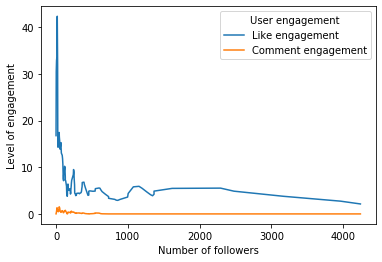

In [13]:
plt.plot(user_engagement_df.followers, gaussian_filter1d(user_engagement_df.like_engagement, sigma=2), label="Like engagement")
plt.plot(user_engagement_df.followers, gaussian_filter1d(user_engagement_df.comment_engagement, sigma=2), label='Comment engagement')
plt.ylabel('Level of engagement')
plt.xlabel('Number of followers')
plt.legend(title='User engagement', loc='best')
plt.show()

In [14]:
# save the dataframes to pickle files
user_engagement_df.to_pickle('user_engagement.pickle')
engagement_df.to_pickle('engagement.pickle')

## Facial features
The second dataframe, containing data related to facial features, contains several columns that seem very related to each other. The following section is dedicated to finding out if some of these can be reduced into less features by combining them. Similar to the *user engagement* section.

In [15]:
# we need the dataframe containing facial features.
facial_df = dataframes[1]
print(facial_df.columns)
facial_df

Index(['image_id', 'face_id', 'face_gender', 'face_gender_confidence',
       'face_age_range_high', 'face_age_range_low', 'face_sunglasses',
       'face_beard', 'face_beard_confidence', 'face_mustache',
       'face_mustache_confidence', 'face_smile', 'face_smile_confidence',
       'eyeglasses', 'eyeglasses_confidence', 'face_emo', 'emo_confidence'],
      dtype='object')


,image_id,face_id,face_gender,face_gender_confidence,face_age_range_high,face_age_range_low,face_sunglasses,face_beard,face_beard_confidence,face_mustache,face_mustache_confidence,face_smile,face_smile_confidence,eyeglasses,eyeglasses_confidence,face_emo,emo_confidence
0,1003944279371027183_703978203,6.0,Female,98.741425,38.0,20.0,False,False,99.998474,False,99.999794,False,99.916168,True,95.395546,SAD,12.660271
1,1003944279371027183_703978203,6.0,Female,98.741425,38.0,20.0,False,False,99.998474,False,99.999794,False,99.916168,True,95.395546,CALM,8.252973
2,1003944279371027183_703978203,6.0,Female,98.741425,38.0,20.0,False,False,99.998474,False,99.999794,False,99.916168,True,95.395546,SURPRISED,24.634266
3,1003944279371027183_703978203,68.0,Male,99.927521,77.0,57.0,False,False,99.981598,False,99.993256,False,84.395294,True,99.420914,HAPPY,53.603287
4,1003944279371027183_703978203,68.0,Male,99.927521,77.0,57.0,False,False,99.981598,False,99.993256,False,84.395294,True,99.420914,SAD,5.509090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86872,993518813923569502_452851338,141.0,Female,100.000000,43.0,26.0,True,False,99.994858,False,99.848000,True,98.452072,True,99.999992,SURPRISED,2.001703
86873,993518813923569502_452851338,141.0,Female,100.000000,43.0,26.0,True,False,99.994858,False,99.848000,True,98.452072,True,99.999992,SAD,1.930684
86874,993518813923569502_452851338,109.0,Female,100.000000,59.0,38.0,False,False,95.497185,False,85.088661,True,97.989082,False,99.799294,HAPPY,99.672775
86875,993518813923569502_452851338,109.0,Female,100.000000,59.0,38.0,False,False,95.497185,False,85.088661,True,97.989082,False,99.799294,CALM,27.599144


The following columns look similar:
- gender
    - face_gender
    - face_gender_confidence
- age
    - face_age_range_high
    - face_age_range_lower
- glasses
    - face_sunglasses
    - eyeglasses
    - eyeglasses_confidence
- facial hair
    - face_beard
    - face_beard_confidence
    - face_mustache
    - face_mustace_confidence
- smile
    - face_smile
    - face_smile_confidence
- emotion
    - face_emo
    - emo_confidence

In [16]:
# we need a row to test the combination of column
facial_df_test_row = facial_df.iloc[0]
facial_df_test_row

image_id                    1003944279371027183_703978203
face_id                                                 6
face_gender                                        Female
face_gender_confidence                            98.7414
face_age_range_high                                    38
face_age_range_low                                     20
face_sunglasses                                     False
face_beard                                          False
face_beard_confidence                             99.9985
face_mustache                                       False
face_mustache_confidence                          99.9998
face_smile                                          False
face_smile_confidence                             99.9162
eyeglasses                                           True
eyeglasses_confidence                             95.3955
face_emo                                              SAD
emo_confidence                                    12.6603
Name: 0, dtype

The following section will be dedicated to combining the columns using the test row created earlier.

In [17]:
# combine the gender into 0, 1, 2 where:
# 0: unknown
# 1: male
# 2: female
def face_gender(actual, confidence):
    """
    Function to calculate a gender as integer based on a given
    gender type and confidence in that gender type.
    
    Parameters:
    actual:string    The actual gender type that it's supposed to be.
    confidence:float The likelyhood that it's actually that gender.
    
    Returns:
    int    0, 1, 2 (0=unknown,1=male,2=female)
    """
    # we need a high confidence level and valid gender
    if confidence < 70 or actual not in ["Male", "Female"]:
        return 0
    
    # male or female
    return 1 if actual == "Male" else 2

# test output
print(face_gender("Male", 70) == 1)
print(face_gender("Female", 90) == 2)
print(face_gender("Male", 40) == 0)
print(face_gender("Gorilla", 100) == 0)

# run on the test row
face_gender(facial_df_test_row.face_gender, facial_df_test_row.face_gender_confidence) == 2

True
True
True
True


True

In [18]:
# combine the age into a single mean
age = (facial_df_test_row.face_age_range_high + facial_df_test_row.face_age_range_low) / 2
age

29.0

In [19]:
# combine the glasses into a single value, 0 or 1 (False or True)
# we don't really care about the sunglasses
glasses = 1 if facial_df_test_row.eyeglasses and facial_df_test_row.eyeglasses_confidence >= 70 else 0
glasses

1

In [20]:
# combine the facial hear columns into a single value, 0 or 1 (False or True):
# face_beard
# face_beard_confidence
# face_mustache
# face_mustace_confidence
beard = 1 if facial_df_test_row.face_beard and facial_df_test_row.face_beard_confidence >= 70 else 0
mustache = 1 if facial_df_test_row.face_mustache and facial_df_test_row.face_mustache_confidence >= 70 else 0
facial_hair = 1 if beard or mustache else 0
facial_hair

0

In [21]:
# combine the smile into a single value, 0 or 1 (False or True)
smile = 1 if facial_df_test_row.face_smile and facial_df_test_row.face_smile_confidence >= 70 else 0
smile

0

In [22]:
# combine the emotion into a single value, integer (by indexing labels)
emo_index = {emo:index for (index, emo) in enumerate(sorted(set(facial_df.face_emo.tolist())))}
emo_index['UNKNOWN'] = 7
print(emo_index)
emotion = emo_index[facial_df_test_row.face_emo] if facial_df_test_row.emo_confidence >= 70 else 7
emotion

{'ANGRY': 0, 'CALM': 1, 'CONFUSED': 2, 'DISGUSTED': 3, 'HAPPY': 4, 'SAD': 5, 'SURPRISED': 6, 'UNKNOWN': 7}


7

Now, all the methods to combine the columns into single values are written and tested. The next section is dedicated to applying the methods on the test row to create a new row. If this is a success, it can be applied on the complete dataframe.

In [23]:
emo_index = {emo:index for (index, emo) in enumerate(sorted(set(facial_df.face_emo.tolist())))}
emo_index['UNKNOWN'] = 7

def combine_columns(row, min_conf=70):
    """
    Function to combine the columns of a facial dataframe row.
    
    Parameters:
    row:pd.Series   Row of the facial_df dataframe.
    
    Returns:
    pd.Series
    """
    gender      = face_gender(row.face_gender, row.face_gender_confidence)
    age         = (row.face_age_range_high + row.face_age_range_low) / 2
    glasses     = 1 if row.eyeglasses and row.eyeglasses_confidence >= min_conf else 0
    beard       = 1 if row.face_beard and row.face_beard_confidence >= min_conf else 0
    mustache    = 1 if row.face_mustache and row.face_mustache_confidence >= min_conf else 0
    facial_hair = 1 if beard or mustache else 0
    smile       = 1 if row.face_smile and row.face_smile_confidence >= min_conf else 0
    emotion     = emo_index[row.face_emo] if row.emo_confidence >= min_conf else 7
    
    # expose a new series
    return pd.Series({
        'image_id': row.image_id,
        'gender': gender,
        'age': age,
        'glasses': glasses,
        'facial_hear': facial_hair,
        'smile': smile,
        'emotion': emotion
    })

# test output
combine_columns(facial_df_test_row)

image_id       1003944279371027183_703978203
gender                                     2
age                                       29
glasses                                    1
facial_hear                                0
smile                                      0
emotion                                    7
dtype: object

In [37]:
# test output on the complete dataframe
facial_df_combined = pd.DataFrame([combine_columns(row) for (idx, row) in facial_df.iterrows()])
facial_df_combined = facial_df_combined.drop_duplicates().reset_index()
facial_df_combined

,index,image_id,gender,age,glasses,facial_hear,smile,emotion
0,0,1003944279371027183_703978203,2,29.0,1,0,0,7
1,3,1003944279371027183_703978203,1,67.0,1,0,0,7
2,6,1000126179441391393_30837828,1,30.5,0,0,1,7
3,8,1000126179441391393_30837828,1,30.5,0,0,1,4
4,9,1000126179441391393_30837828,1,34.5,0,0,0,7
...,...,...,...,...,...,...,...,...
44672,86865,993518813923569502_452851338,2,29.0,0,0,1,4
44673,86866,993518813923569502_452851338,2,29.0,0,0,1,7
44674,86871,993518813923569502_452851338,2,34.5,1,0,1,4
44675,86874,993518813923569502_452851338,2,48.5,0,0,1,4


There are still multiple rows per image. These can be reduce into single rows by adding four new columns: unknown_gender, male, female, person_count.

In [39]:
# get rid of the duplicated index
facial_df_combined = facial_df_combined.drop('index', 1)
facial_df_combined

,image_id,gender,age,glasses,facial_hear,smile,emotion
0,1003944279371027183_703978203,2,29.0,1,0,0,7
1,1003944279371027183_703978203,1,67.0,1,0,0,7
2,1000126179441391393_30837828,1,30.5,0,0,1,7
3,1000126179441391393_30837828,1,30.5,0,0,1,4
4,1000126179441391393_30837828,1,34.5,0,0,0,7
...,...,...,...,...,...,...,...
44672,993518813923569502_452851338,2,29.0,0,0,1,4
44673,993518813923569502_452851338,2,29.0,0,0,1,7
44674,993518813923569502_452851338,2,34.5,1,0,1,4
44675,993518813923569502_452851338,2,48.5,0,0,1,4


In [57]:
# we need to add the three columns
facial_df_combined['unkown_gender'] = facial_df_combined.apply(lambda x: 1 if x['gender'] == 0 else 0, axis=1)
facial_df_combined['male'] = facial_df_combined.apply(lambda x: 1 if x['gender'] == 1 else 0, axis = 1)
facial_df_combined['female'] = facial_df_combined.apply(lambda x: 1 if x['gender'] == 2 else 0, axis = 1)
facial_df_combined.drop('gender', inplace=True, axis=1)
facial_df_combined

,image_id,age,glasses,facial_hear,smile,emotion,unkown_gender,male,female,person_count
0,1003944279371027183_703978203,29.0,1,0,0,7,0,0,1,1
1,1003944279371027183_703978203,67.0,1,0,0,7,0,1,0,1
2,1000126179441391393_30837828,30.5,0,0,1,7,0,1,0,1
3,1000126179441391393_30837828,30.5,0,0,1,4,0,1,0,1
4,1000126179441391393_30837828,34.5,0,0,0,7,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
44672,993518813923569502_452851338,29.0,0,0,1,4,0,0,1,1
44673,993518813923569502_452851338,29.0,0,0,1,7,0,0,1,1
44674,993518813923569502_452851338,34.5,1,0,1,4,0,0,1,1
44675,993518813923569502_452851338,48.5,0,0,1,4,0,0,1,1


image_id\
age - average \
glasses - average \
facial_hear - average \
smile - average \
emotion - majority vote \
unkown_gender - sum\
male - sum\
female - sum

In [119]:
# apply the methods on the dataframe
facial_df_combined_aggr = facial_df_combined.groupby('image_id').apply(lambda x: pd.Series({
    'age': x['age'].mean(),
    'glasses': x['glasses'].mean(),
    'emotion': sp.stats.mode(x['emotion'])[0][0],
    'facial_hear': x['facial_hear'].mean(),
    'smile': x['smile'].mean(),
    'unkown_gender': x['unkown_gender'].sum(),
    'male': x['male'].sum(),
    'female': x['female'].sum()
}))

In [121]:
facial_df_combined_aggr.corr().style.applymap(lambda x: 'color:green' if x > 0.5 else 'color:red')

,age,glasses,emotion,facial_hear,smile,unkown_gender,male,female
age,1,0.112535,0.000217679,0.21382,-0.0282289,-0.0636054,0.179799,-0.054246
glasses,0.112535,1,0.0432023,0.107767,0.00321951,-0.00395615,0.0311455,-0.0754364
emotion,0.000217679,0.0432023,1,0.133805,-0.393109,0.0304662,0.0453959,-0.147926
facial_hear,0.21382,0.107767,0.133805,1,-0.0404418,-0.00777007,0.140449,-0.219443
smile,-0.0282289,0.00321951,-0.393109,-0.0404418,1,0.00486747,0.0689481,0.217144
unkown_gender,-0.0636054,-0.00395615,0.0304662,-0.00777007,0.00486747,1,0.0264973,-0.00236892
male,0.179799,0.0311455,0.0453959,0.140449,0.0689481,0.0264973,1,-0.0501119
female,-0.054246,-0.0754364,-0.147926,-0.219443,0.217144,-0.00236892,-0.0501119,1


In [122]:
# save to a pickle file
facial_df_combined_aggr.to_pickle('facial_features.pickle')

In [145]:
# we can now merge the aggregated facial features dataframe with the 
# image metadata dataframes
merged_df = pd.merge(dataframes[2], facial_df_combined_aggr, how="left", on="image_id")
print(merged_df.shape, facial_df_combined_aggr.shape, dataframes[2].shape)

# save the merged pickle
merged_df.to_pickle('imagedata_with_facial_features.pickle')

(41206, 26) (15957, 8) (41206, 18)


All datasets have been handled, except for the first one. This dataset contains data related to anp sentiment and emotional scores. There are, however, many anp labels. This number can be reduced using only the most frequent labels out of a lemmatized set of labels.

In [27]:
# we need the first dataset
anp_df = dataframes[0]

# we need a new sanitizer
sanitizer = Sanitizer()

# we need a lemmatized set of anp labels, seperated in adjectives and nouns
lemmatized_adjectives = [sanitizer.lemmatize(label.split('_')[0]) for label in anp_df.loc[:, 'anp_label']]
lemmatized_nouns = [sanitizer.lemmatize(label.split('_')[1]) for label in anp_df.loc[:, 'anp_label']]
len(lemmatized_adjectives), len(lemmatized_nouns)

(325941, 325941)

In [65]:
# output the most common adjectives and nouns
print("Adjectives:\n{}\n".format(Counter(lemmatized_adjectives).most_common(10)))
print("Nouns:\n{}\n".format(Counter(lemmatized_nouns).most_common(10)))

# output combination of them
print("Combined:\n", Counter(list(zip(lemmatized_adjectives, lemmatized_nouns))).most_common(50))

Adjectives:
[('cute', 9841), ('hot', 7606), ('happy', 7404), ('funny', 6891), ('old', 6597), ('fake', 5999), ('sexy', 5764), ('good', 5612), ('beautiful', 5401), ('big', 5125)]

Nouns:
[('food', 9195), ('dog', 9079), ('cat', 8892), ('hair', 7181), ('baby', 5648), ('quote', 5280), ('face', 5259), ('day', 5120), ('girl', 4583), ('boy', 3816)]

Combined:
 [(('inspirational', 'quote'), 2248), (('fake', 'vintage'), 1821), (('funny', 'quote'), 1753), (('true', 'story'), 1579), (('small', 'dog'), 1548), (('fake', 'lomo'), 1506), (('cute', 'dog'), 1408), (('silly', 'face'), 1382), (('wise', 'word'), 1312), (('cute', 'cat'), 1168), (('sour', 'cream'), 1157), (('comic', 'life'), 1110), (('comic', 'sans'), 1104), (('real', 'talk'), 1088), (('real', 'food'), 1003), (('mixed', 'breed'), 959), (('cute', 'guy'), 952), (('healthy', 'food'), 933), (('cute', 'couple'), 927), (('classic', 'toy'), 921), (('sexy', 'boy'), 903), (('hot', 'sauce'), 877), (('dyed', 'hair'), 870), (('good', 'day'), 869), (('cu

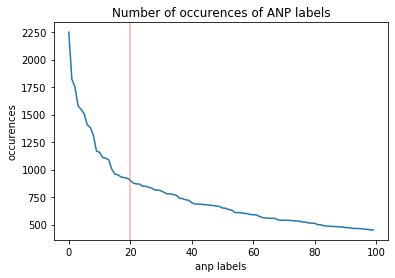

In [153]:
# get the top 100 most common anp labels
counted_anps = Counter(list(zip(lemmatized_adjectives, lemmatized_nouns))).most_common(100)

# create vertical line at x = 20
ax = plt.gca()
plt.plot(range(len(counted_anps)), [x[1] for x in counted_anps])
ax.axvline(20, c="tomato", alpha=0.5)
plt.ylabel('occurences')
plt.xlabel('anp labels')
plt.title('Number of occurences of ANP labels')
plt.show()

In [96]:
# output the most common anp labels
print(*[" ".join(label) for (label, c) in counted_anps[:20]], sep="\n")

inspirational quote
fake vintage
funny quote
true story
small dog
fake lomo
cute dog
silly face
wise word
cute cat
sour cream
comic life
comic sans
real talk
real food
mixed breed
cute guy
healthy food
cute couple
classic toy


In [29]:
len(set(dataframes[0].loc[:, 'image_id'])), len(set(dataframes[0].loc[:, 'anp_label'])), len(set(dataframes[0].loc[:, 'emotion_label']))

(41292, 3863, 24)